# 1. Install library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install datasets evaluate --upgrade
!python -m spacy download en_core_web_sm

In [3]:
!pip install --upgrade pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 38.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2


In [4]:
!pip install datasets
!pip install torchtext
!pip install spacy

In [5]:
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
from datasets import load_dataset, Dataset

import torchtext
import tqdm

# 2. Processing data

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/dialogs.txt', sep='\t', names=['question', 'answer'])

df.head()

question  \
0               hi, how are you doing?   
1        i'm fine. how about yourself?   
2  i'm pretty good. thanks for asking.   
3    no problem. so how have you been?   
4     i've been great. what about you?   

                                     answer  
0             i'm fine. how about yourself?  
1       i'm pretty good. thanks for asking.  
2         no problem. so how have you been?  
3          i've been great. what about you?  
4  i've been good. i'm in school right now.

In [7]:
dataset = Dataset.from_pandas(df)

In [8]:
dataset

Dataset({
    features: ['question', 'answer'],
    num_rows: 3725
})

In [9]:
# split data into train, test and validation set
train_data, valid_data, test_data = (
    dataset[:3000],
    dataset[3000:3300],
    dataset[3300:],
)

In [16]:
from datasets import Dataset

train_data = Dataset.from_dict(train_data)
test_data = Dataset.from_dict(test_data)
valid_data = Dataset.from_dict(valid_data)

AttributeError: 'Dataset' object has no attribute 'items'

In [11]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [12]:
# Load model spacy for tokenizer
en_nlp = spacy.load("en_core_web_sm")

In [13]:
"""
Example
"""
string = "Who does mental illness affect"

[token.text for token in en_nlp.tokenizer(string)]

['Who', 'does', 'mental', 'illness', 'affect']

In [14]:
import re
def tokenize_example(example, en_nlp, max_length, lower, sos_token, eos_token):
    """
    Tokenizes an example containing English

    Args:
        example (dict): A dictionary containing question and answer
        en_nlp: English spaCy tokenizer.
        max_length (int): Maximum length of tokens to consider.
        lower (bool): Whether to convert tokens to lowercase.
        sos_token (str): Start-of-sequence token.
        eos_token (str): End-of-sequence token.

    Returns:
        dict: A dictionary containing tokenized of question and answer
    """

    process_question = re.sub('[^a-zA-Z]', ' ', example["question"])
    process_answer = re.sub('[^a-zA-Z]', ' ', example["answer"])
    # Tokenize question
    ques_tokens = [token.text for token in en_nlp.tokenizer(process_question)][:max_length]

    # Tokenize answer
    ans_tokens = [token.text for token in en_nlp.tokenizer(process_answer)][:max_length]


    # Convert tokens to lowercase if specified
    if lower:
        ques_tokens = [token.lower() for token in ques_tokens]
        ans_tokens = [token.lower() for token in ans_tokens]

    # Add start-of-sequence and end-of-sequence tokens
    ques_tokens = [sos_token] + ques_tokens + [eos_token]
    ans_tokens = [sos_token] + ans_tokens + [eos_token]

    return {"ques_tokens": ques_tokens, "ans_tokens": ans_tokens}


In [15]:
max_length = 1000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/425 [00:00<?, ? examples/s]

In [17]:
train_data[0]

{'question': 'hi, how are you doing?',
 'answer': "i'm fine. how about yourself?",
 'ques_tokens': ['<sos>', 'hi', ' ', 'how', 'are', 'you', 'doing', '<eos>'],
 'ans_tokens': ['<sos>',
  'i',
  'm',
  'fine',
  ' ',
  'how',
  'about',
  'yourself',
  '<eos>']}

In [18]:
def prepare_vocab(row_data):
    vocab = row_data["ques_tokens"] + row_data["ans_tokens"]
    vocab = set(i for i in vocab)
    row_data["build_vocab"] = list(vocab)
    return row_data


In [19]:
train_data = train_data.map(prepare_vocab)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [20]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

'''
Build vocab for english language
'''
en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["build_vocab"],
    min_freq=min_freq,
    specials=special_tokens,
)


In [21]:
# Get the index of the unknown token in the English vocabulary
unk_index = en_vocab[unk_token]

# Get the index of the padding token in the English vocabulary
pad_index = en_vocab[pad_token]

In [22]:
# Set the default index for the English vocabulary to the index of the unknown token
en_vocab.set_default_index(unk_index)


In [23]:
tokens = ['do', 'you', 'like', 'it']
en_vocab.lookup_indices(tokens)

[15, 6, 25, 10]

In [24]:
en_vocab.lookup_tokens(en_vocab.lookup_indices(tokens))

['do', 'you', 'like', 'it']

In [25]:
def numericalize_example(example, en_vocab):
    """
    Numericalizes the tokenized example using provided vocabularies.

    Args:
        example (dict): A dictionary containing tokenized question, answer
        en_vocab: English vocabulary.

    Returns:
        dict: A dictionary containing numericalized question and answer
    """
    ques_ids = en_vocab.lookup_indices(example["ques_tokens"])
    ans_ids = en_vocab.lookup_indices(example["ans_tokens"])

    return {"ques_ids": ques_ids, "ans_ids": ans_ids}

In [26]:
fn_kwargs = {"en_vocab": en_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/425 [00:00<?, ? examples/s]

In [27]:
train_data[0]

{'question': 'hi, how are you doing?',
 'answer': "i'm fine. how about yourself?",
 'ques_tokens': ['<sos>', 'hi', ' ', 'how', 'are', 'you', 'doing', '<eos>'],
 'ans_tokens': ['<sos>',
  'i',
  'm',
  'fine',
  ' ',
  'how',
  'about',
  'yourself',
  '<eos>'],
 'build_vocab': ['m',
  ' ',
  'about',
  'hi',
  '<eos>',
  'how',
  'you',
  '<sos>',
  'doing',
  'i',
  'fine',
  'are',
  'yourself'],
 'ques_ids': [2, 1490, 5, 38, 20, 6, 162, 3],
 'ans_ids': [2, 4, 30, 610, 5, 38, 33, 527, 3]}

In [28]:
# Define the data type for the torch tensors
data_type = "torch"

# Define the columns to format
format_columns = ["ques_ids", "ans_ids"]

# Format the training data
train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

# Format the validation data
valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

# Format the test data
test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)


In [29]:
def get_collate_fn(pad_index):
    """
    Returns a collate function for padding sequences in a batch.

    Args:
        pad_index (int): Index of the padding token.

    Returns:
        function: A collate function that pads sequences in a batch.
    """
    def collate_fn(batch):
        """
        Collate function to pad sequences in a batch.

        Args:
            batch (list): A list of examples, where each example is a dictionary containing numericalized of question and answer

        Returns:
            dict: A dictionary containing padded sequences for question ans answer
        """
        batch_ques_ids = [example["ques_ids"] for example in batch]
        batch_ans_ids = [example["ans_ids"] for example in batch]

        batch_ques_ids = nn.utils.rnn.pad_sequence(batch_ques_ids, padding_value=pad_index)
        batch_ans_ids = nn.utils.rnn.pad_sequence(batch_ans_ids, padding_value=pad_index)

        # Construct the batch dictionary with padded sequences
        batch = {
            "batch_ques_ids": batch_ques_ids,
            "batch_ans_ids": batch_ans_ids,
        }
        return batch

    return collate_fn


In [30]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    """
    Returns a DataLoader for a given dataset with specified batch size and padding index.

    Args:
        dataset: The dataset to create the DataLoader from.
        batch_size (int): The size of each batch.
        pad_index (int): Index of the padding token.
        shuffle (bool, optional): Whether to shuffle the data. Default is False.

    Returns:
        torch.utils.data.DataLoader: A DataLoader for the dataset.
    """
    # Get the collate function for padding sequences
    collate_fn = get_collate_fn(pad_index)

    # Create a DataLoader with the provided dataset, batch size, collate function, and shuffle option
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader


In [31]:
batch_size = 64

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

# 3. Define model

In [32]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        """
        Initialize the Encoder module.

        Args:
            input_dim (int): Dimension of the input vocabulary.
            embedding_dim (int): Dimension of the word embeddings.
            hidden_dim (int): Dimension of the hidden states of the LSTM.
            n_layers (int): Number of layers in the LSTM.
            dropout (float): Dropout probability.
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        # Initialize embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        # Initialize LSTM layer
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        # Initialize dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        """
        Forward pass of the Encoder module.

        Args:
            src (torch.Tensor): Input tensor representing the source sequence.

        Returns:
            torch.Tensor: Hidden state tensor for the last time step.
            torch.Tensor: Cell state tensor for the last time step.
        """
        # Apply dropout to the embedded input
        embedded = self.dropout(self.embedding(src))
        # Forward pass through the LSTM layer
        outputs, (hidden, cell) = self.rnn(embedded)
        # Return the hidden and cell state tensors for the last time step
        return hidden, cell


In [33]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        """
        Initialize the Decoder module.

        Args:
            output_dim (int): Dimension of the output vocabulary.
            embedding_dim (int): Dimension of the word embeddings.
            hidden_dim (int): Dimension of the hidden states of the LSTM.
            n_layers (int): Number of layers in the LSTM.
            dropout (float): Dropout probability.
        """
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        # Initialize embedding layer
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        # Initialize LSTM layer
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        # Initialize fully connected output layer
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        # Initialize dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        """
        Forward pass of the Decoder module.

        Args:
            input (torch.Tensor): Input tensor representing the previous decoder output.
            hidden (torch.Tensor): Hidden state tensor from the previous time step.
            cell (torch.Tensor): Cell state tensor from the previous time step.

        Returns:
            torch.Tensor: Output tensor containing the predicted logits for the next token.
            torch.Tensor: Hidden state tensor for the current time step.
            torch.Tensor: Cell state tensor for the current time step.
        """
        # Add a dimension to input tensor
        input = input.unsqueeze(0)
        # Apply dropout to the embedded input
        embedded = self.dropout(self.embedding(input))
        # Forward pass through the LSTM layer
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # Remove the added dimension and pass through the fully connected output layer
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell


In [34]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        """
        Initialize the Seq2Seq model with encoder, decoder, and device.

        Args:
            encoder: Encoder module.
            decoder: Decoder module.
            device (torch.device): Device for computation.
        """
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        # Check if hidden dimensions and number of layers match between encoder and decoder
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio):
        """
        Forward pass of the Seq2Seq model.

        Args:
            src (torch.Tensor): Source sequence tensor.
            trg (torch.Tensor): Target sequence tensor.
            teacher_forcing_ratio (float): Ratio of teacher forcing during training.

        Returns:
            torch.Tensor: Decoder outputs tensor.
        """
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # Initialize outputs tensor
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # Encode the source sequence
        hidden, cell = self.encoder(src)
        # Initialize decoder input as the first token in target sequence
        input = trg[0, :]
        # Iterate over each token in target sequence
        for t in range(1, trg_length):
            # Forward pass through decoder
            output, hidden, cell = self.decoder(input, hidden, cell)
            # Save decoder output
            outputs[t] = output
            # Decide whether to use teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            # Get next input token
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs


In [35]:
input_dim = len(en_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 200
decoder_embedding_dim = 200
hidden_dim = 64
n_layers = 4
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [36]:
def init_weights(m):
    """
    Initialize the weights of the model using uniform distribution.

    Args:
        m (torch.nn.Module): The model for which weights are initialized.
    """
    # Iterate over all named parameters in the model
    for name, param in m.named_parameters():
        # Initialize the parameter data with values sampled from a uniform distribution between -0.08 and 0.08
        nn.init.uniform_(param.data, -0.08, 0.08)

# Apply the init_weights function to initialize the weights of the model
model.apply(init_weights)


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(1917, 200)
    (rnn): LSTM(200, 64, num_layers=4, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(1917, 200)
    (rnn): LSTM(200, 64, num_layers=4, dropout=0.5)
    (fc_out): Linear(in_features=64, out_features=1917, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 1,227,277 trainable parameters


# 4. Define training process

In [38]:
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [39]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [40]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    """
    Perform one training epoch.

    Args:
        model (torch.nn.Module): The model to train.
        data_loader (torch.utils.data.DataLoader): DataLoader for the training data.
        optimizer: The optimizer to use for training.
        criterion: The loss function criterion.
        clip (float): Value for gradient clipping.
        teacher_forcing_ratio (float): The ratio of teacher forcing to use during training.
        device: Device to perform computations on (e.g., "cpu" or "cuda").

    Returns:
        float: Average loss for the epoch.
    """
    # Set the model to train mode
    model.train()
    epoch_loss = 0
    # Iterate over batches in the data loader
    for i, batch in enumerate(data_loader):
        # Move source and target sequences to the specified device
        src = batch["batch_ques_ids"].to(device)
        trg = batch["batch_ans_ids"].to(device)


        # Zero gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(src, trg, teacher_forcing_ratio)
        # Calculate output dimension
        output_dim = output.shape[-1]
        # Remove the start token from the output and flatten it
        output = output[1:].view(-1, output_dim)
        # Remove the start token from the target and flatten it
        trg = trg[1:].view(-1)
        # Calculate the loss
        loss = criterion(output, trg)
        # Backward pass
        loss.backward()
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Update model parameters
        optimizer.step()
        # Accumulate loss for the epoch
        epoch_loss += loss.item()
    # Return the average loss for the epoch
    return epoch_loss / len(data_loader)


In [41]:
def evaluate_fn(model, data_loader, criterion, device):
    """
    Evaluate the model on the validation or test set.

    Args:
        model (torch.nn.Module): The model to evaluate.
        data_loader (torch.utils.data.DataLoader): DataLoader for the validation or test data.
        criterion: The loss function criterion.
        device: Device to perform computations on (e.g., "cpu" or "cuda").

    Returns:
        float: Average loss for the evaluation.
    """
    # Set the model to evaluation mode
    model.eval()
    epoch_loss = 0
    # Disable gradient computation
    with torch.no_grad():
        # Iterate over batches in the data loader
        for i, batch in enumerate(data_loader):
            # Move source and target sequences to the specified device
            src = batch["batch_ques_ids"].to(device)
            trg = batch["batch_ans_ids"].to(device)
            # Forward pass without teacher forcing (teacher_forcing_ratio=0)
            output = model(src, trg, 0)
            # Calculate output dimension
            output_dim = output.shape[-1]
            # Remove the start token from the output and flatten it
            output = output[1:].view(-1, output_dim)
            # Remove the start token from the target and flatten it
            trg = trg[1:].view(-1)
            # Calculate the loss
            loss = criterion(output, trg)
            # Accumulate loss for the epoch
            epoch_loss += loss.item()
    # Return the average loss for the evaluation
    return epoch_loss / len(data_loader)


In [42]:
n_epochs = 300  # Number of epochs for training
clip = 1.0  # Gradient clipping threshold
teacher_forcing_ratio = 0.5  # Ratio of teacher forcing during training

best_valid_loss = float("inf")  # Initialize best validation loss to infinity

import numpy as np
import matplotlib.pyplot as plt

# Lists to store training and validation losses
train_losses = []
valid_losses = []

# Iterate over epochs
for epoch in tqdm.tqdm(range(n_epochs)):
    # Perform one training epoch
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )

    # Evaluate on the validation set
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )

    # Save the model if the validation loss improves
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut1-model.pt")

    if (epoch +1) % 5 == 0:
        # Print training and validation loss for the epoch
        print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
        print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

    # Append the training and validation losses to their respective lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)





  2%|▏         | 5/300 [00:11<10:05,  2.05s/it]

	Train Loss:   5.143 | Train PPL: 171.169
	Valid Loss:   5.039 | Valid PPL: 154.293


  3%|▎         | 10/300 [00:20<09:27,  1.96s/it]

	Train Loss:   5.004 | Train PPL: 149.047
	Valid Loss:   5.042 | Valid PPL: 154.732


  5%|▌         | 15/300 [00:29<08:08,  1.71s/it]

	Train Loss:   4.892 | Train PPL: 133.279
	Valid Loss:   5.081 | Valid PPL: 161.011


  7%|▋         | 20/300 [00:38<08:13,  1.76s/it]

	Train Loss:   4.810 | Train PPL: 122.676
	Valid Loss:   5.078 | Valid PPL: 160.447


  8%|▊         | 25/300 [00:47<08:25,  1.84s/it]

	Train Loss:   4.728 | Train PPL: 113.038
	Valid Loss:   5.099 | Valid PPL: 163.898


 10%|█         | 30/300 [00:55<07:33,  1.68s/it]

	Train Loss:   4.676 | Train PPL: 107.305
	Valid Loss:   5.130 | Valid PPL: 168.952


 12%|█▏        | 35/300 [01:05<07:37,  1.73s/it]

	Train Loss:   4.609 | Train PPL: 100.416
	Valid Loss:   5.158 | Valid PPL: 173.736


 13%|█▎        | 40/300 [01:14<07:52,  1.82s/it]

	Train Loss:   4.576 | Train PPL:  97.138
	Valid Loss:   5.163 | Valid PPL: 174.742


 15%|█▌        | 45/300 [01:22<07:41,  1.81s/it]

	Train Loss:   4.537 | Train PPL:  93.366
	Valid Loss:   5.203 | Valid PPL: 181.814


 17%|█▋        | 50/300 [01:31<07:12,  1.73s/it]

	Train Loss:   4.517 | Train PPL:  91.588
	Valid Loss:   5.218 | Valid PPL: 184.543


 18%|█▊        | 55/300 [01:40<07:20,  1.80s/it]

	Train Loss:   4.467 | Train PPL:  87.113
	Valid Loss:   5.261 | Valid PPL: 192.694


 20%|██        | 60/300 [01:50<08:04,  2.02s/it]

	Train Loss:   4.418 | Train PPL:  82.902
	Valid Loss:   5.283 | Valid PPL: 196.889


 22%|██▏       | 65/300 [01:58<06:37,  1.69s/it]

	Train Loss:   4.376 | Train PPL:  79.528
	Valid Loss:   5.319 | Valid PPL: 204.156


 23%|██▎       | 70/300 [02:07<06:42,  1.75s/it]

	Train Loss:   4.351 | Train PPL:  77.539
	Valid Loss:   5.342 | Valid PPL: 208.906


 25%|██▌       | 75/300 [02:16<07:03,  1.88s/it]

	Train Loss:   4.312 | Train PPL:  74.611
	Valid Loss:   5.392 | Valid PPL: 219.746


 27%|██▋       | 80/300 [02:25<06:09,  1.68s/it]

	Train Loss:   4.312 | Train PPL:  74.622
	Valid Loss:   5.376 | Valid PPL: 216.079


 28%|██▊       | 85/300 [02:34<06:17,  1.75s/it]

	Train Loss:   4.274 | Train PPL:  71.826
	Valid Loss:   5.412 | Valid PPL: 223.989


 30%|███       | 90/300 [02:43<06:36,  1.89s/it]

	Train Loss:   4.250 | Train PPL:  70.099
	Valid Loss:   5.410 | Valid PPL: 223.628


 32%|███▏      | 95/300 [02:51<05:38,  1.65s/it]

	Train Loss:   4.236 | Train PPL:  69.119
	Valid Loss:   5.428 | Valid PPL: 227.617


 33%|███▎      | 100/300 [03:00<05:40,  1.70s/it]

	Train Loss:   4.185 | Train PPL:  65.692
	Valid Loss:   5.464 | Valid PPL: 236.031


 35%|███▌      | 105/300 [03:09<06:05,  1.87s/it]

	Train Loss:   4.157 | Train PPL:  63.884
	Valid Loss:   5.498 | Valid PPL: 244.196


 37%|███▋      | 110/300 [03:17<05:15,  1.66s/it]

	Train Loss:   4.156 | Train PPL:  63.807
	Valid Loss:   5.518 | Valid PPL: 249.111


 38%|███▊      | 115/300 [03:26<05:18,  1.72s/it]

	Train Loss:   4.099 | Train PPL:  60.291
	Valid Loss:   5.545 | Valid PPL: 255.933


 40%|████      | 120/300 [03:35<05:32,  1.85s/it]

	Train Loss:   4.035 | Train PPL:  56.539
	Valid Loss:   5.581 | Valid PPL: 265.270


 42%|████▏     | 125/300 [03:43<04:51,  1.67s/it]

	Train Loss:   4.047 | Train PPL:  57.213
	Valid Loss:   5.620 | Valid PPL: 275.908


 43%|████▎     | 130/300 [03:52<04:51,  1.72s/it]

	Train Loss:   4.030 | Train PPL:  56.285
	Valid Loss:   5.638 | Valid PPL: 280.890


 45%|████▌     | 135/300 [04:02<05:01,  1.83s/it]

	Train Loss:   3.994 | Train PPL:  54.295
	Valid Loss:   5.638 | Valid PPL: 280.798


 47%|████▋     | 140/300 [04:10<04:28,  1.68s/it]

	Train Loss:   3.973 | Train PPL:  53.165
	Valid Loss:   5.649 | Valid PPL: 284.062


 48%|████▊     | 145/300 [04:19<04:24,  1.71s/it]

	Train Loss:   3.956 | Train PPL:  52.228
	Valid Loss:   5.715 | Valid PPL: 303.479


 50%|█████     | 150/300 [04:28<04:32,  1.82s/it]

	Train Loss:   3.912 | Train PPL:  49.982
	Valid Loss:   5.728 | Valid PPL: 307.206


 52%|█████▏    | 155/300 [04:36<04:02,  1.67s/it]

	Train Loss:   3.904 | Train PPL:  49.613
	Valid Loss:   5.787 | Valid PPL: 325.952


 53%|█████▎    | 160/300 [04:45<03:59,  1.71s/it]

	Train Loss:   3.867 | Train PPL:  47.796
	Valid Loss:   5.758 | Valid PPL: 316.678


 55%|█████▌    | 165/300 [04:54<04:04,  1.81s/it]

	Train Loss:   3.870 | Train PPL:  47.936
	Valid Loss:   5.822 | Valid PPL: 337.727


 57%|█████▋    | 170/300 [05:02<03:39,  1.69s/it]

	Train Loss:   3.833 | Train PPL:  46.215
	Valid Loss:   5.817 | Valid PPL: 336.069


 58%|█████▊    | 175/300 [05:11<03:31,  1.70s/it]

	Train Loss:   3.820 | Train PPL:  45.584
	Valid Loss:   5.821 | Valid PPL: 337.332


 60%|██████    | 180/300 [05:20<03:34,  1.79s/it]

	Train Loss:   3.805 | Train PPL:  44.947
	Valid Loss:   5.893 | Valid PPL: 362.552


 62%|██████▏   | 185/300 [05:29<03:15,  1.70s/it]

	Train Loss:   3.743 | Train PPL:  42.213
	Valid Loss:   5.893 | Valid PPL: 362.603


 63%|██████▎   | 190/300 [05:39<03:17,  1.79s/it]

	Train Loss:   3.749 | Train PPL:  42.457
	Valid Loss:   5.909 | Valid PPL: 368.461


 65%|██████▌   | 195/300 [05:48<03:12,  1.83s/it]

	Train Loss:   3.730 | Train PPL:  41.670
	Valid Loss:   5.930 | Valid PPL: 376.088


 67%|██████▋   | 200/300 [05:56<02:51,  1.72s/it]

	Train Loss:   3.787 | Train PPL:  44.103
	Valid Loss:   5.950 | Valid PPL: 383.576


 68%|██████▊   | 205/300 [06:05<02:41,  1.70s/it]

	Train Loss:   3.728 | Train PPL:  41.588
	Valid Loss:   5.994 | Valid PPL: 401.013


 70%|███████   | 210/300 [06:14<02:40,  1.79s/it]

	Train Loss:   3.663 | Train PPL:  38.989
	Valid Loss:   6.043 | Valid PPL: 421.335


 72%|███████▏  | 215/300 [06:22<02:27,  1.74s/it]

	Train Loss:   3.656 | Train PPL:  38.725
	Valid Loss:   6.045 | Valid PPL: 421.917


 73%|███████▎  | 220/300 [06:31<02:16,  1.70s/it]

	Train Loss:   3.611 | Train PPL:  37.000
	Valid Loss:   6.058 | Valid PPL: 427.583


 75%|███████▌  | 225/300 [06:40<02:13,  1.78s/it]

	Train Loss:   3.632 | Train PPL:  37.771
	Valid Loss:   6.059 | Valid PPL: 427.952


 77%|███████▋  | 230/300 [06:49<02:03,  1.76s/it]

	Train Loss:   3.602 | Train PPL:  36.685
	Valid Loss:   6.149 | Valid PPL: 468.119


 78%|███████▊  | 235/300 [06:57<01:48,  1.67s/it]

	Train Loss:   3.560 | Train PPL:  35.180
	Valid Loss:   6.169 | Valid PPL: 477.543


 80%|████████  | 240/300 [07:06<01:44,  1.74s/it]

	Train Loss:   3.559 | Train PPL:  35.112
	Valid Loss:   6.191 | Valid PPL: 488.191


 82%|████████▏ | 245/300 [07:15<01:38,  1.79s/it]

	Train Loss:   3.550 | Train PPL:  34.797
	Valid Loss:   6.176 | Valid PPL: 481.184


 83%|████████▎ | 250/300 [07:23<01:23,  1.68s/it]

	Train Loss:   3.557 | Train PPL:  35.062
	Valid Loss:   6.189 | Valid PPL: 487.462


 85%|████████▌ | 255/300 [07:32<01:19,  1.76s/it]

	Train Loss:   3.543 | Train PPL:  34.570
	Valid Loss:   6.234 | Valid PPL: 509.659


 87%|████████▋ | 260/300 [07:41<01:13,  1.83s/it]

	Train Loss:   3.478 | Train PPL:  32.406
	Valid Loss:   6.290 | Valid PPL: 539.022


 88%|████████▊ | 265/300 [07:49<00:59,  1.69s/it]

	Train Loss:   3.514 | Train PPL:  33.566
	Valid Loss:   6.263 | Valid PPL: 524.674


 90%|█████████ | 270/300 [07:58<00:52,  1.75s/it]

	Train Loss:   3.451 | Train PPL:  31.535
	Valid Loss:   6.320 | Valid PPL: 555.448


 92%|█████████▏| 275/300 [08:07<00:46,  1.88s/it]

	Train Loss:   3.396 | Train PPL:  29.840
	Valid Loss:   6.356 | Valid PPL: 576.043


 93%|█████████▎| 280/300 [08:16<00:33,  1.68s/it]

	Train Loss:   3.427 | Train PPL:  30.785
	Valid Loss:   6.347 | Valid PPL: 570.655


 95%|█████████▌| 285/300 [08:25<00:26,  1.73s/it]

	Train Loss:   3.404 | Train PPL:  30.071
	Valid Loss:   6.361 | Valid PPL: 578.552


 97%|█████████▋| 290/300 [08:33<00:18,  1.87s/it]

	Train Loss:   3.321 | Train PPL:  27.697
	Valid Loss:   6.449 | Valid PPL: 632.102


 98%|█████████▊| 295/300 [08:42<00:08,  1.67s/it]

	Train Loss:   3.367 | Train PPL:  28.977
	Valid Loss:   6.440 | Valid PPL: 626.289


100%|██████████| 300/300 [08:51<00:00,  1.77s/it]

	Train Loss:   3.328 | Train PPL:  27.875
	Valid Loss:   6.453 | Valid PPL: 634.408


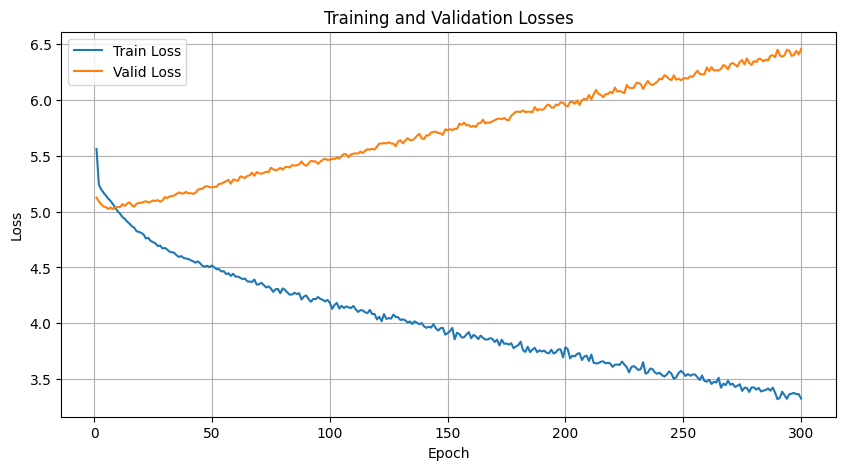

In [43]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

# 5. Inference model

In [44]:
model.load_state_dict(torch.load("tut1-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 5.095 | Test PPL: 163.132 |


In [45]:
def chat(
    sentence,
    model=model,
    en_nlp=en_nlp,
    en_vocab=en_vocab,
    lower=lower,
    sos_token=sos_token,
    eos_token=eos_token,
    device=device,
    max_output_length=25,
):
    """
    inferrence model

    Args:
        sentence (str or List[str]): The input sentence to chat, either as a string or a list of tokens.
        model: The trained translation model.
        en_nlp: English spaCy tokenizer.
        en_vocab: English vocabulary.
        lower (bool): Whether to convert tokens to lowercase.
        sos_token (str): Start-of-sequence token.
        eos_token (str): End-of-sequence token.
        device: Device to perform computations on (e.g., "cpu" or "cuda").
        max_output_length (int, optional): Maximum length of the output sequence. Default is 25.

    Returns:
        List[str]: The respopnse sentence as a list of tokens.
    """
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        # Tokenize the input sentence
        if isinstance(sentence, str):
            tokens = [token.text for token in en_nlp.tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]

        # Optionally convert tokens to lowercase
        if lower:
            tokens = [token.lower() for token in tokens]

        # Add start-of-sequence and end-of-sequence tokens
        tokens = [sos_token] + tokens + [eos_token]

        # Convert tokens to indices using the English vocabulary
        ids = en_vocab.lookup_indices(tokens)

        # Convert indices to a tensor and move it to the specified device
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)

        # Encode the input sentence using the encoder of the model
        hidden, cell = model.encoder(tensor)

        # Initialize the input for the decoder with the start-of-sequence token
        inputs = en_vocab.lookup_indices([sos_token])

        # Translate the input sentence
        for _ in range(max_output_length):
            # Convert the input token to a tensor and move it to the specified device
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)

            # Perform one step of decoding using the decoder of the model
            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)

            # Predict the next token
            predicted_token = output.argmax(-1).item()

            # Add the predicted token to the input for the next step
            inputs.append(predicted_token)

            # Stop translating if the end-of-sequence token is predicted
            if predicted_token == en_vocab[eos_token]:
                break

        # Convert the predicted tokens to tokens using the English vocabulary
        tokens = en_vocab.lookup_tokens(inputs)

    # Return the translated sentence
    return tokens


In [46]:
test_data = [
    "it's an upstairs unit.",
     "that's good, because i don't want to live under people with loud feet.",
     "and it's a corner unit.",
     "that's great. we won't have neighbors on both sides of us.",
     'no pets are allowed.',
     "perfect. we don't have to listen to barking dogs.",
     'and there are only six units in the whole building.',
     'did you call the manager?', "yes. he said he'd come over tomorrow.",
     'did he say what time?']

for ques in test_data:
    response = chat(ques)
    print(response)

['<sos>', 'i', ' ', '<eos>']
['<sos>', 'i', ' ', 'you', '<eos>']
['<sos>', 'i', ' ', '<eos>']
['<sos>', 'i', ' ', 'you', '<eos>']
['<sos>', 'i', ' ', '<eos>']
['<sos>', 'i', ' ', 'you', '<eos>']
['<sos>', 'i', ' ', ' ', ' ', '<eos>']
['<sos>', 'i', ' ', ' ', '<eos>']
['<sos>', 'i', ' ', '<eos>']
['<sos>', 'i', ' ', '<eos>']
